# Lomas: Client demo

In [36]:
import requests

<Response [404]>

In [38]:
r = requests.get("http://lomas_server" + "/" + "metrics/", headers={"Content-type": "application/json", "Accept": "*/*"})
r

<Response [404]>

In [39]:
!curl http://otel-collector:9464/metrics

curl: (7) Failed to connect to otel-collector port 9464 after 5 ms: Couldn't connect to server


This notebook showcases how researcher could use the Lomas platform. It explains the different functionnalities provided by the `lomas-client` library to interact with the secure server.

The secure data are never visible by researchers. They can only access to differentially private responses via queries to the server.

Each user has access to one or multiple projects and for each dataset has a limited budget with $\epsilon$ and $\delta$ values.

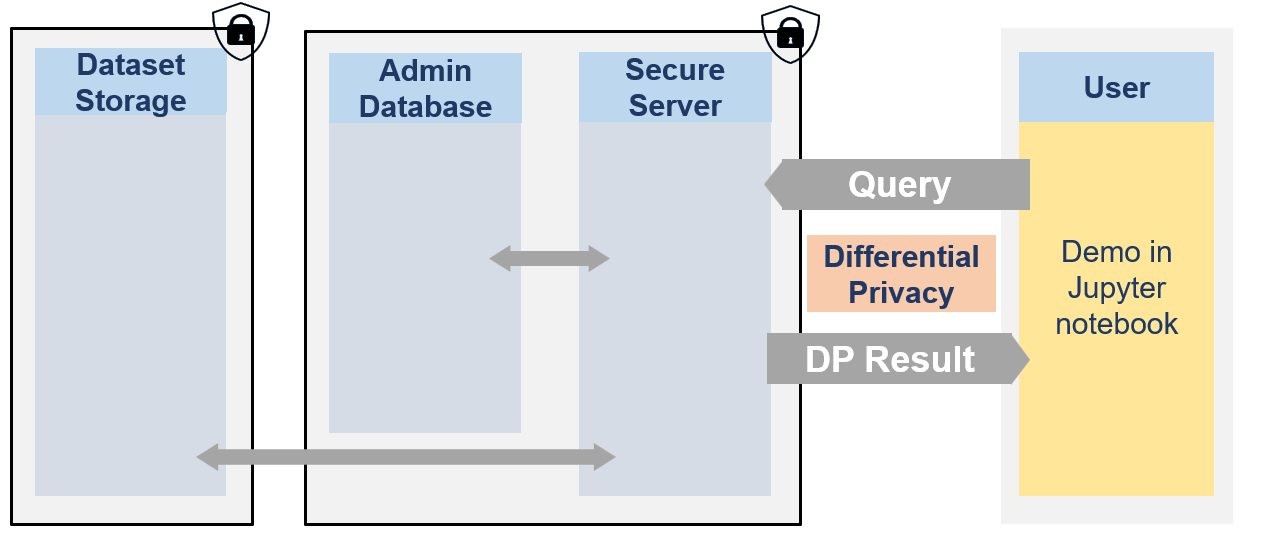

In [1]:
from IPython.display import Image
Image(filename="images/image_demo_client.png", width=800)

🐧🐧🐧
In this notebook the researcher is a penguin researcher named Dr. Antarctica. She aims to do a grounbdbreaking research on various penguins dimensions.

Therefore, the powerful queen Icerbegina 👑 had the data collected. But in order to get the penguins to agree to participate she promised them that no one would be able to look at the data and that no one would be able to guess the bill width of any specific penguin (which is very sensitive information) from the data. Nobody! Not even the researchers. The queen hence stored the data on the Secure Data Disclosure Server and only gave a small budget to Dr. Antarctica.

This is not a problem for Dr. Antarctica as she does not need to see the data to make statistics thanks to the Secure Data Disclosure Client library `lomas-client`. 
🐧🐧🐧

## Step 1: Install the library
To interact with the secure server on which the data is stored, Dr.Antartica first needs to install the library `lomas-client` on her local developping environment. 

It can be installed via the pip command:

In [2]:
!pip install lomas-client

  Installing build dependencies ... one
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... one
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for lomas-client: filename=lomas_client-0.3.5-py3-none-any.whl size=15827 sha256=b4e2a82f9d6db686cdb5e7a9824166e787e1d80972320c8294d61acd7a94c000
  Stored in directory: /root/.cache/pip/wheels/19/9a/c5/c00a710a3877b2c3584f36105082b34ded1a1c3491fb4deddc
  Created wheel for lomas-core: filename=lomas_core-0.3.5-py3-none-any.whl size=11469 sha256=8390f68756f3322b8f67718573573e0655b7b0bb9f7e6bbeca1f568deb13c077
  Stored in directory: /root/.cache/pip/wheels/89/0e/b3/d0fd9425a0b247d12d1bb4688168613aade3afa4fe344c538c
Successfully built lomas-client lomas-core


In [2]:
from lomas_client import Client
import numpy as np

## Step 2: Initialise the client

Once the library is installed, a Client object must be created. It is responsible for sending sending requests to the server and processing responses in the local environment. It enables a seamless interaction with the server. 

To create the client, Dr. Antartica needs to give it a few parameters:
- a url: the root application endpoint to the remote secure server.
- user_name: her name as registered in the database (Dr. Alice Antartica)
- dataset_name: the name of the dataset that she wants to query (PENGUIN)

She will only be able to query on the real dataset if the queen Icergina has previously made her an account in the database, given her access to the PENGUIN dataset and has given her some epsilon and delta credit (as is done in the Admin Notebook for Users and Datasets management).

In [70]:
APP_URL = "http://lomas_server"
USER_NAME = "Dr. Antartica"
DATASET_NAME = "PENGUIN"
client = Client(url=APP_URL, user_name = USER_NAME, dataset_name = DATASET_NAME)

And that's it for the preparation. She is now ready to use the various functionnalities offered by `lomas_client`.

## Step 3: Understand the functionnalities of the library

### a. Getting dataset metadata

Dr. Antartica has never seen the data and as a first step to understand what is available to her, she would like to check the metadata of the dataset. Therefore, she just needs to call the `get_dataset_metadata()` function of the client. As this is public information, this does not cost any budget.

This function returns metadata information in a format based on [SmartnoiseSQL dictionary format](https://docs.smartnoise.org/sql/metadata.html#dictionary-format), where among other, there is information about all the available columns, their type, bound values (see Smartnoise page for more details). Any metadata is required for Smartnoise-SQL is also required here and additional information such that the different categories in a string type column column can be added.

In [71]:
penguin_metadata = client.get_dataset_metadata()
penguin_metadata

{'max_ids': 1,
 'rows': 344,
 'row_privacy': True,
 'censor_dims': False,
 'columns': {'species': {'private_id': False,
   'nullable': False,
   'max_partition_length': None,
   'max_influenced_partitions': None,
   'max_partition_contributions': None,
   'type': 'string',
   'cardinality': 3,
   'categories': ['Adelie', 'Chinstrap', 'Gentoo']},
  'island': {'private_id': False,
   'nullable': False,
   'max_partition_length': None,
   'max_influenced_partitions': None,
   'max_partition_contributions': None,
   'type': 'string',
   'cardinality': 3,
   'categories': ['Torgersen', 'Biscoe', 'Dream']},
  'bill_length_mm': {'private_id': False,
   'nullable': False,
   'max_partition_length': None,
   'max_influenced_partitions': None,
   'max_partition_contributions': None,
   'type': 'float',
   'precision': 64,
   'lower': 30.0,
   'upper': 65.0},
  'bill_depth_mm': {'private_id': False,
   'nullable': False,
   'max_partition_length': None,
   'max_influenced_partitions': None,
   'm

Based on this Dr. Antartica knows that there are 7 columns, 3 of string type (species, island, sex) with their associated categories (i.e. the species column has 3 possibilities: 'Adelie', 'Chinstrap', 'Gentoo') and 4 of float type (bill length, bill depth, flipper length and body mass) with their associated bounds (i.e. the body mass of penguin ranges from 2000 to 7000 gramms). She also knows based on the field `max_ids: 1` that each penguin can only be once in the dataset and on the field `row_privacy: True` that each row represents a single penguin. Finally, she learns that there are 344 rows in the dataset and hence 344 penguins.

In [72]:
NB_PENGUINS = penguin_metadata["rows"]

### b. Get a dummy dataset

Now, that she has seen and understood the metadata, she wants to get an even better understanding of the dataset (but is still not able to see it). A solution to have an idea of what the dataset looks like it to create a dummy dataset. 

Based on the public metadata of the dataset, a random dataframe can be created created. By default, there will be 100 rows and the seed is set to 42 to ensure reproducibility, but these 2 variables can be changed to obtain different dummy datasets.
Getting a dummy dataset does not affect the budget as there is no differential privacy here. It is not a synthetic dataset and all that could be learn here is already present in the public metadata (it is created randomly on the fly based on the metadata).

Dr. Antartica first create a dummy dataset with 100 rows and chooses a seed of 0.

In [73]:
NB_ROWS = 100
SEED = 0

In [74]:
df_dummy = client.get_dummy_dataset(
    nb_rows = NB_ROWS, 
    seed = SEED
)

print(df_dummy.shape)
df_dummy.head()

(100, 7)


species     island  bill_length_mm  bill_depth_mm  flipper_length_mm  \
0     Gentoo     Biscoe       46.799577      16.196816         239.680123   
1  Chinstrap      Dream       38.133052      14.875077         208.332005   
2  Chinstrap  Torgersen       58.065820      19.725266         154.021822   
3     Adelie  Torgersen       62.323556      14.951074         221.148682   
4     Adelie      Dream       39.314560      18.776879         206.902585   

   body_mass_g     sex  
0  3010.840470  FEMALE  
1  6689.525543    MALE  
2  2473.883392    MALE  
3  2024.497075  FEMALE  
4  3614.604018    MALE

### c. Check privacy loss budget ε, δ (initial, current, remaining)

It is the first time that Dr. Antartica connects to the server and she wants to know how much buget has beeen assigned to her.
Therefore, she calls the fonction `get_initial_budget`.

In [75]:
client.get_initial_budget()

InitialBudgetResponse(initial_epsilon=10.0, initial_delta=0.005)

She sees that she has 10.0 epsilon and 0.005 epsilon at her disposal.

Then she checks her total spent budget `get_total_spent_budget`. As she only did queries on metadata on dummy dataframes, this should still be 0.

In [76]:
client.get_total_spent_budget()

SpentBudgetResponse(total_spent_epsilon=0.0, total_spent_delta=0.0)

It will also be useful to know what the remaining budget is. Therefore, she calls the function `get_remaining_budget`. It just substarcts the total spent budget from the initial budget.

In [77]:
client.get_remaining_budget()

RemainingBudgetResponse(remaining_epsilon=10.0, remaining_delta=0.005)

As expected, for now the remaining budget is equal to the inital budget.

## Step 4: Use DP libraries to analyse the dataset
Available DP libraires are:
- Smartnoise-SQL for SQL-like queries
- Smartnoise-Synth for generating synthetic datasets
- OpenDP for summary statistics
- DiffPrivLib for training Machine Learning models

For each library, there are three possibilities: 
- estimate the cost of a query (will NOT spend privacy loss budget)
- query on a 'dummy' dataset (explained below) (will NOT spend privacy loss budget)
- query on the private dataset (WILL SPEND PRIVACY LOSS BUDGET)

### a. Compute average bill length with Smartnoise-SQL

Dr. Antartica wants to know the average bill length of penguins. Therefore, she will use `smartnoise-sql` library and write the associated SQL command.

In [78]:
# Average bill length in mm
QUERY = "SELECT AVG(bill_length_mm) AS avg_bill_length_mm FROM df"

#### Estimate cost of a query with smartnoise-sql
She will then estimate the cost of this query. In the various DP librairies the budget that will by used by a query in the server might be slightly different than what is asked by the user in inptu. The `estimate cost` function of each library returns the cost that will effectively be sent and deduced if the query is applied on the sensitive dataset.

The user can then decide to use the budget or modify it. Again, of course, this will not impact the user's budget.

Dr. Antartica checks the budget that computing the average bill length will really cost her if she asks the query with an `epsilon` and a `delta`.

In [79]:
EPSILON = 0.5
DELTA = 1e-4

In [80]:
cost = client.smartnoise_sql.cost(
    query = QUERY, 
    epsilon = EPSILON, 
    delta = DELTA
)
cost

CostResponse(epsilon=1.0, delta=4.999999999999449e-05)

In [81]:
print(f"This query would actually cost her {cost.epsilon} epsilon and {cost.delta} delta.")

This query would actually cost her 1.0 epsilon and 4.999999999999449e-05 delta.


She decides that it is good enough.

#### Query average bill length on dummy dataset with smartnoise-sql
She now wants to start querying the real dataset for her research. 

However, her budget is limited and it would be a waste to spend it by mistake on a coding error. Therefore the client/server pipeline has functionnal testing capabilities for the users. It is possible to test a query on a `dummy` dataset to ensure that everything is working properly. Dr. Antartica will not be able to use the results of a dummy query for her analysis (as the data is random) but if the query on the dummy dataset works, she can be confident that her query will also work on the real dataset.
This functionnal testing on the dummy does not have any impact on the budget as it is on random data only.

To test on the dummy data instead of the real data, the function call is exactly the same with the only exception of the flag `dummy=True`. In the following cell, she will test with `smartnoise_query` but it is the same flag for `opendp.query`. She can optionnaly give two additional parameters to set the seed and the number of rows of the dummy dataset.

Another more advanced possibility for functionnal tests with the dummy is to compare results of queries on a local dummy and the remote dummy with a very high budget: 
- create a local dummy on the notebook with a specific seed and number of rows
- compute locally the wanted query on this local dummy with python functions like numpy
- query the server on the same remote dummy with (`dummy=True`, same seed and same number of row) and a very big buget to limit noise as much as possible (don't worry this won't cost any real budget)
- compare and verify that the local and remote dummy have similar results.

Dr. Antartica will follow the best practice and now try the query to get the average bill length (in mm) on the dummy dataset. She does not forget to 
- set the `dummy` flag to True
- set very high budget values to be able to compare results with a similar local dummy (with the same seed and number of rows) if she wants to verify that the function do what is expected. Here she will just check that the number of rows is close to what she sets as parameter.

In [82]:
# On the remote server dummy dataframe
dummy_res = client.smartnoise_sql.query(
    query = QUERY,
    epsilon = 100.0,
    delta = 0.99,
    dummy = True, 
    nb_rows = NB_ROWS,
    seed = SEED
)

In [83]:
print(f"Average bill length in remote dummy: {np.round(dummy_res.result.df['avg_bill_length_mm'][0], 2)}mm.")

Average bill length in remote dummy: 48.59mm.


No functionnal errors happened and the average bill length is within reasonable bounds. She is now even more confident in using her query on the server.

#### Query average bill length on private dataset with smartnoise-sql
Now that all the safeguard functions were tested, Dr. Antartica is ready to query on the real dataset and get a differentially private response of the number of penguins and average bill length. By default, the flag `dummy` is False so setting it is optional. She uses the values of `epsilon` and `delta` that she selected just before.

Careful: This command DOES spend the budget of the user and the remaining budget is updated for every query.

In [84]:
client.get_remaining_budget()

RemainingBudgetResponse(remaining_epsilon=10.0, remaining_delta=0.005)

In [85]:
response = client.smartnoise_sql.query(
    query = QUERY,  
    epsilon = EPSILON, 
    delta = DELTA,
    dummy = False # APPLIED ON SENSITIVE DATA, WILL SPEND BUDGET
)

In [86]:
avg_bill_length = np.round(response.result.df['avg_bill_length_mm'].iloc[0], 2)
print(f"Average bill length of penguins in real data: {avg_bill_length}mm.")

Average bill length of penguins in real data: 44.7mm.


After each query on the real dataset, the budget informations are also returned to the researcher. It is possible possible to check the remaining budget again afterwards:

In [88]:
client.get_remaining_budget()

RemainingBudgetResponse(remaining_epsilon=9.0, remaining_delta=0.004950000000000006)

As can be seen in `get_total_spent_budget()`, it is the budget estimated with `estimate_smartnoise_cost()` that was spent.

In [89]:
client.get_total_spent_budget()

SpentBudgetResponse(total_spent_epsilon=1.0, total_spent_delta=4.999999999999449e-05)

Dr. Antartica has now a differentially private estimation of the number of penguins in the dataset and is confident to use the library for the rest of her analyses.

### b. Compute confidence interval with opendp

In [90]:
import opendp as dp
import opendp.transformations as trans
import opendp.measurements as meas

She now wants the confidence interval of bill length in mm. She already has the number of penguins and the average from the metadata and previous smartnoise-sql queries respectively. She now needs the variance value.

#### Prepare opendp pipeline and verify on dummy
She checks the metadata of the columns again to use the relevant values in the pipeline.

In [91]:
penguin_metadata["columns"]

{'species': {'private_id': False,
  'nullable': False,
  'max_partition_length': None,
  'max_influenced_partitions': None,
  'max_partition_contributions': None,
  'type': 'string',
  'cardinality': 3,
  'categories': ['Adelie', 'Chinstrap', 'Gentoo']},
 'island': {'private_id': False,
  'nullable': False,
  'max_partition_length': None,
  'max_influenced_partitions': None,
  'max_partition_contributions': None,
  'type': 'string',
  'cardinality': 3,
  'categories': ['Torgersen', 'Biscoe', 'Dream']},
 'bill_length_mm': {'private_id': False,
  'nullable': False,
  'max_partition_length': None,
  'max_influenced_partitions': None,
  'max_partition_contributions': None,
  'type': 'float',
  'precision': 64,
  'lower': 30.0,
  'upper': 65.0},
 'bill_depth_mm': {'private_id': False,
  'nullable': False,
  'max_partition_length': None,
  'max_influenced_partitions': None,
  'max_partition_contributions': None,
  'type': 'float',
  'precision': 64,
  'lower': 13.0,
  'upper': 23.0},
 'flipp

She can define the columns names and the bounds of the relevant column.

In [92]:
columns = list(penguin_metadata["columns"].keys())

In [67]:
bill_length_min = penguin_metadata['columns']['bill_length_mm']['lower']
bill_length_max = penguin_metadata['columns']['bill_length_mm']['upper']
bill_length_min, bill_length_max

(30.0, 65.0)

She can now define the pipeline of the transformation to have the variance that she wants on the data:

In [68]:
bill_length_transformation_pipeline = (
    trans.make_split_dataframe(separator=",", col_names=columns) >>
    trans.make_select_column(key="bill_length_mm", TOA=str) >>
    trans.then_cast_default(TOA=float) >>
    trans.then_clamp(bounds=(bill_length_min, bill_length_max)) >>
    trans.then_resize(size=NB_PENGUINS, constant=avg_bill_length) >>
    trans.then_variance()
)

However, when she tries to execute it on the server, she has an error (see below). 

In [69]:
# No instruction for noise addition mechanism: Expect to fail !!!
client.opendp.query(
    opendp_pipeline = bill_length_transformation_pipeline,
    dummy=True
)

ValidationError: 1 validation error for tagged-union[InvalidQueryExceptionModel,ExternalLibraryExceptionModel,UnauthorizedAccessExceptionModel,InternalServerExceptionModel]
  JSON input should be string, bytes or bytearray [type=json_type, input_value={'type': 'InvalidQueryExc...cessed in this server.'}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.10/v/json_type

This is because the server will only allow measurement pipeline with differentially private results. She adds Laplacian noise to the pipeline and should be able to instantiate the pipeline.

In [30]:
var_bill_length_measurement_pipeline = (
    bill_length_transformation_pipeline >>
    meas.then_laplace(scale=5.0) # Noise addition mechanism instructions
)

Now that there is a measurement, she is able to apply the pipeline on the dummy dataset of the server.

In [31]:
dummy_var_res = client.opendp.query(
    opendp_pipeline = var_bill_length_measurement_pipeline, 
    dummy=True
)
print(f"Dummy result for variance: {np.round(dummy_var_res.result.value, 2)}")

Dummy result for variance: 29.55


#### Estimate cost with opendp

With opendp, the function `opendp.cost` is particularly useful to estimate the used `epsilon` and `delta` based on the `scale` value.

In [30]:
cost_res = client.opendp.cost(
    opendp_pipeline = var_bill_length_measurement_pipeline
)
cost_res

CostResponse(epsilon=0.7122093023265228, delta=0.0)

#### Execute pipeline on real dataset with opendp

She can now execute the query on the real dataset.

In [31]:
var_res = client.opendp.query(
    opendp_pipeline = var_bill_length_measurement_pipeline, 
)

In [32]:
var_bill_length = np.round(var_res.result.value, 2)
print(f"Variance of bill length: {var_bill_length} (from opendp query).")

Variance of bill length: 35.06 (from opendp query).


#### Postprocessing: no additional privacy risk with DP

She can now do all the postprocessing that she wants with the returned data without adding any privacy risk. 

In [33]:
# Get standard error
standard_error = np.sqrt(var_bill_length / NB_PENGUINS)
print(f"Standard error of bill length: {np.round(standard_error, 2)}.")

Standard error of bill length: 0.32.


In [34]:
 # Compute the 95% confidence interval
ZSCORE = 1.96
lower_bound = np.round(avg_bill_length - ZSCORE * standard_error, 2)
upper_bound = np.round(avg_bill_length + ZSCORE * standard_error, 2)
print(f"The 95% confidence interval of the bill length of all penguins is [{lower_bound}, {upper_bound}].")

The 95% confidence interval of the bill length of all penguins is [42.89, 44.15].


### c. Train a DP Machine Learning model with DiffPrivLib

In [35]:
from sklearn.pipeline import Pipeline
from diffprivlib import models
import pandas as pd

She now wants a model to predict the species of a penguin based on bill depth. Therefore, she uses a Random Forest classifier from DiffPrivLib library.

#### Prepare Random Forest Classifier pipeline on dummy with DiffPrivLib

In [36]:
feature_columns = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']
target_columns = ['species']

In [37]:
def get_bounds(cols_metadata, columns):
    lower = [cols_metadata[col]["lower"] for col in columns]
    upper = [cols_metadata[col]["upper"] for col in columns]
    return (lower, upper)

In [38]:
bounds = get_bounds(penguin_metadata['columns'], columns=feature_columns)
bounds

([30.0, 13.0, 150.0, 2000.0], [65.0, 23.0, 250.0, 7000.0])

In [39]:
dpl_pipeline = Pipeline([
    ('rf', models.RandomForestClassifier(
        n_estimators=10, 
        epsilon = 2.0, 
        bounds=bounds, 
        classes=['Adelie', 'Chinstrap', 'Gentoo'])
    ),
])

In [40]:
dummy_response = client.diffprivlib.query(
    pipeline = dpl_pipeline,
    feature_columns = feature_columns,
    target_columns = target_columns,
    test_size = 0.2,
    test_train_split_seed = 1,
    dummy = True
)
model = dummy_response.result.model
model

Pipeline(steps=[('rf',
                 RandomForestClassifier(accountant=BudgetAccountant(spent_budget=[(2.0, 0)]),
                                        bounds=(array([  30.,   13.,  150., 2000.]),
                                                array([  65.,   23.,  250., 7000.])),
                                        classes=['Adelie', 'Chinstrap',
                                                 'Gentoo'],
                                        epsilon=2.0))])

#### Estimate budget of Linear Regression with DiffPrivLib

In [41]:
cost_res = client.diffprivlib.cost(
    dpl_pipeline,
    feature_columns = feature_columns,
    target_columns = target_columns,
    test_size = 0.2,
    test_train_split_seed = 1
)
cost_res

CostResponse(epsilon=2.0, delta=0.0)

#### Train random forest classifier on sensitive data with DiffPrivLib

In [42]:
response = client.diffprivlib.query(
    pipeline = dpl_pipeline,
    feature_columns = feature_columns,
    target_columns = target_columns,
    test_size = 0.1,
    test_train_split_seed = 1,
    dummy = False
)

In [43]:
# Return the mean accuracy. 
model_score = response.result.score

In [44]:
f"The model has a mean accuracy of {np.round(model_score, 2)}. It is a harsh metric because we are in a multi-label classification case."

'The model has a mean accuracy of 0.32. It is a harsh metric because we are in a multi-label classification case.'

In [45]:
model = response.result.model
model

Pipeline(steps=[('rf',
                 RandomForestClassifier(accountant=BudgetAccountant(spent_budget=[(2.0, 0)]),
                                        bounds=(array([  30.,   13.,  150., 2000.]),
                                                array([  65.,   23.,  250., 7000.])),
                                        classes=['Adelie', 'Chinstrap',
                                                 'Gentoo'],
                                        epsilon=2.0))])

In [46]:
x_to_predict = pd.DataFrame({
    'bill_length_mm': [30.0], 'bill_depth_mm': [20.0], 'flipper_length_mm': [170.0], 'body_mass_g': [5000.0]
})
predictions = model.predict(x_to_predict)[0]
f"For these feature values, the predicted species is is {predictions}."

'For these feature values, the predicted species is is Adelie.'

### d. Get a Synthetic Dataset with Smartnoise-Synth

Finally she gets a synthetic dataset to do the rest of her analysis. She chooses to only train on a subset on 3 columns: "island", "bill_length_mm" and "bill_depth_mm" but if we wanted she could train on the whole dataset.
She also decides to use the `patectgan` synthesizer and keep all other default parameters.

#### Train patectgan synthesizer on dummy data with Smartnoise-Synth

In [47]:
res_dummy = client.smartnoise_synth.query(
    synth_name="patectgan",
    select_cols = ["island", "bill_length_mm", "bill_depth_mm"],
    epsilon=1.0,
    dummy=True,
)
dummy_synth_df = res_dummy.result.df_samples

In [48]:
dummy_synth_df.head()

island  bill_length_mm  bill_depth_mm
0  Dream       59.189283      18.603612
1  Dream       45.893746      17.438823
2  Dream       48.175088      16.088652
3  Dream       57.958338      17.529872
4  Dream       51.722943      19.493872

#### Estimate cost of training patectgan synthesizer with Smartnoise-Synth

In [49]:
res_cost = client.smartnoise_synth.cost(
    synth_name="patectgan",
    epsilon=1.0,
    select_cols = ["island", "bill_length_mm", "bill_depth_mm"],
)
res_cost

CostResponse(epsilon=1.0, delta=0.00015673368198174188)

#### Train patectgan synthesizer on private data with Smartnoise-Synth

In [50]:
res = client.smartnoise_synth.query(
    synth_name="patectgan",
    select_cols = ["island", "bill_length_mm", "bill_depth_mm"],
    epsilon=1.0,
    dummy=False,
)
synth_df = res.result.df_samples

In [51]:
synth_df.head()

island  bill_length_mm  bill_depth_mm
0      Dream       52.053493      15.699640
1      Dream       47.705728      17.678879
2  Torgersen       56.875727      16.196799
3     Biscoe       38.807937      19.253387
4      Dream       46.332477      15.361980

Out of curiosity, she checks the average bill length and variance of bill length on this dataset.

In [52]:
synth_mean = np.round(synth_df["bill_length_mm"].mean(), 2)
synth_variance = np.round(synth_df["bill_length_mm"].var(), 2)

In [53]:
print(
    f"The average with Smartnoise-SQL on private data was {avg_bill_length}.\n"
    + f"The average with Smartnoise-Synth on synthetic data is {synth_mean}."
)

The average with Smartnoise-SQL on private data was 43.52.
The average with Smartnoise-Synth on synthetic data is 44.53.


In [54]:
print(
    f"The variance with opendp on private data was {var_bill_length}.\n"
    + f"The variance with Smartnoise-Synth on synthetic data is {synth_variance}."
)

The variance with opendp on private data was 35.06.
The variance with Smartnoise-Synth on synthetic data is 36.25.


## Step 4: See archives of queries

She now wants to verify all the queries that she did on the real data. It is possible because an archive of all queries is kept in a secure database. With a function call she can see her queries, budget and associated responses.

In [55]:
previous_queries = client.get_previous_queries()
len(previous_queries)

5

In [56]:
# Smartnoise-SQL
avg_bill_length_query = previous_queries[0]
avg_bill_length_query

{'user_name': 'Dr. Antartica',
 'dataset_name': 'PENGUIN',
 'dp_librairy': 'smartnoise_sql',
 'client_input': {'dataset_name': 'PENGUIN',
  'query_str': 'SELECT AVG(bill_length_mm) AS avg_bill_length_mm FROM df',
  'epsilon': 0.5,
  'delta': 0.0001,
  'mechanisms': {},
  'postprocess': True},
 'response': {'epsilon': 1.0,
  'delta': 4.999999999999449e-05,
  'requested_by': 'Dr. Antartica',
  'result': {'res_type': 'smartnoise_sql',
   'df': {'index': [0],
    'columns': ['avg_bill_length_mm'],
    'data': [[43.75587056284081]],
    'index_names': [None],
    'column_names': [None]}}},
 'timestamp': 1732024136.80644}

In [57]:
# OpenDP
var_bill_length_query = previous_queries[1]
var_bill_length_query

{'user_name': 'Dr. Antartica',
 'dataset_name': 'PENGUIN',
 'dp_librairy': 'smartnoise_sql',
 'client_input': {'dataset_name': 'PENGUIN',
  'query_str': 'SELECT AVG(bill_length_mm) AS avg_bill_length_mm FROM df',
  'epsilon': 0.5,
  'delta': 0.0001,
  'mechanisms': {},
  'postprocess': True},
 'response': {'epsilon': 1.0,
  'delta': 4.999999999999449e-05,
  'requested_by': 'Dr. Antartica',
  'result': {'res_type': 'smartnoise_sql',
   'df': {'index': [0],
    'columns': ['avg_bill_length_mm'],
    'data': [[43.52246114623609]],
    'index_names': [None],
    'column_names': [None]}}},
 'timestamp': 1732024185.9737833}

In [58]:
# DiffPrivLib
reg_bill_length_query = previous_queries[2]
reg_bill_length_query

{'user_name': 'Dr. Antartica',
 'dataset_name': 'PENGUIN',
 'dp_librairy': 'opendp',
 'client_input': {'dataset_name': 'PENGUIN',
  'opendp_json': Measurement(
      input_domain   = AtomDomain(T=String),
      input_metric   = SymmetricDistance(),
      output_measure = MaxDivergence(f64)),
  'fixed_delta': None},
 'response': {'epsilon': 0.7122093023265228,
  'delta': 0.0,
  'requested_by': 'Dr. Antartica',
  'result': {'res_type': 'opendp', 'value': 35.063144457712596}},
 'timestamp': 1732024233.7957816}

In [59]:
# Smartnoise-Synth
sysynth_query = previous_queries[3]
sysynth_query

{'user_name': 'Dr. Antartica',
 'dataset_name': 'PENGUIN',
 'dp_librairy': 'diffprivlib',
 'client_input': {'dataset_name': 'PENGUIN',
  'diffprivlib_json': '{"module": "diffprivlib", "version": "0.6.5", "pipeline": [{"type": "_dpl_type:RandomForestClassifier", "name": "rf", "params": {"n_estimators": 10, "n_jobs": 1, "random_state": null, "verbose": 0, "warm_start": false, "max_depth": 5, "epsilon": 2.0, "bounds": {"_tuple": true, "_items": [[30.0, 13.0, 150.0, 2000.0], [65.0, 23.0, 250.0, 7000.0]]}, "classes": ["Adelie", "Chinstrap", "Gentoo"], "shuffle": false, "accountant": "_dpl_instance:BudgetAccountant"}}]}',
  'feature_columns': ['bill_length_mm',
   'bill_depth_mm',
   'flipper_length_mm',
   'body_mass_g'],
  'target_columns': ['species'],
  'test_size': 0.1,
  'test_train_split_seed': 1,
  'imputer_strategy': 'drop'},
 'response': {'epsilon': 2.0,
  'delta': 0.0,
  'requested_by': 'Dr. Antartica',
  'result': {'res_type': 'diffprivlib',
   'score': 0.3235294117647059,
   'mo